In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../..")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from librep.datasets.har.loaders import (
    KuHar_BalancedView20HzMotionSenseEquivalent
)

2022-11-10 13:07:33.560847: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-10 13:07:33.560867: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
from librep.transforms.topo_ae import (
    TopologicalDimensionalityReduction,
    CustomTopoDimRedTransform
)
from librep.transforms import UMAP
from sklearn.manifold import TSNE
from experiments.Topological_ae.Experiment_utils import *
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [6]:
# MotionSense Loader
loader = KuHar_BalancedView20HzMotionSenseEquivalent(
    root_dir="../../../data/views/KuHar/balanced_20Hz_motionsense_equivalent-v1", 
    download=False
)

# Print the readme (optional)
loader.print_readme()

# Balanced KuHar View Resampled to 20Hz

This is a view from [KuHar v5](https://data.mendeley.com/datasets/45f952y38r/5) that was spllited into 3s windows and was resampled to 20Hz using the [FFT method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample). 

The data was first splitted in three sets: train, validation and test. Each one with the following proportions:
- Train: 70% of samples
- Validation: 10% of samples
- Test: 20% of samples

After splits, the datasets were balanced in relation to the activity code column, that is, each subset have the same number of activitiy samples.

**NOTE**: Each subset contain samples from distinct users, that is, samples of one user belongs exclusivelly to one of three subsets.

## Activity codes
- 0: stair down (485 train, 34 validation, 41 test) 
- 1: stair up (485 train, 34 validation, 41 test) 
- 2: sit (485 train, 34 validation, 41 test) 
- 3: stand (485 train, 34 validation, 41 test) 
- 4: walk (485 train, 34 validation, 41 test) 
- 5: run (485 train, 34 validation, 41 test) 
 

## Standartized activity codes
- 0: sit (485 train, 34 validation, 41 test) 
- 1: stand (485 train, 34 validation, 41 test) 
- 2: walk (485 train, 34 validation, 41 test) 
- 3: stair up (485 train, 34 validation, 41 test) 
- 4: stair down (485 train, 34 validation, 41 test) 
- 5: run (485 train, 34 validation, 41 test) 
      




In [7]:
# Load the dataset
# If concat_train_validation is true, return a tuple (train+validation, test)
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=3114, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=246, features=360, no. window=6, label_columns='standard activity code')

In [8]:
train_HD = np.array(train_val[:][0])
train_Y = np.array(train_val[:][1])
test_HD = np.array(test[:][0])
test_Y = np.array(test[:][1])

In [9]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(3114, 360) (3114,) (246, 360) (246,)


# Aplicar FFT

In [10]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(
    transforms=[fft_transform],
    new_window_name_prefix="fft."
)

In [11]:
train_dataset_fft = transformer(train_val)
# validation_dataset_fft = transformer(validation_dataset)
test_dataset_fft = transformer(test)

In [12]:
print(train_dataset_fft.X.shape)
# print(validation_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(3114, 180)
(246, 180)


In [13]:
print(np.max(train_dataset_fft.X))

1199.4899017510002


In [14]:
train_dataset_fft.X

array([[ 5.02447148,  1.61251322,  6.76232259, ...,  0.61856338,
         1.44669533,  0.76661466],
       [ 3.57299732, 10.83009996, 11.81552738, ...,  0.33707892,
         0.57328104,  1.73237447],
       [18.92428589, 22.85409918, 26.51434407, ...,  1.28323215,
         0.74769824,  1.31400771],
       ...,
       [37.2112309 , 19.57891073, 22.52651437, ...,  1.15467725,
         1.07398967,  3.41019869],
       [58.00138092, 13.80286188, 11.50619146, ...,  1.93344645,
         6.26234023,  2.55844602],
       [22.52434513, 15.52963032,  4.92321122, ...,  5.31483603,
         3.63845394,  1.15570768]])

In [15]:
train_HD = train_dataset_fft.X
train_LD = None
train_Y = train_dataset_fft.y
test_HD = test_dataset_fft.X
test_LD = None
test_Y = test_dataset_fft.y

In [16]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(3114, 180) (3114,) (246, 180) (246,)


# Visualization helper

In [17]:
# 0: sit (569 train, 101 validation, 170 test)
# 1: stand (569 train, 101 validation, 170 test)
# 2: walk (569 train, 101 validation, 170 test)
# 3: stair up (569 train, 101 validation, 170 test)
# 4: stair down (569 train, 101 validation, 170 test)
# 5: run (569 train, 101 validation, 170 test)
def visualize(X, Y):
    labels = ['sit', 'stand', 'walk', 'stair up', 'stair down', 'run']
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
    groups = df.groupby('label')
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='.', linestyle='', ms=8, label=labels[name])
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [18]:
# Variables to reuse
model_dim = 10
model_epc = 700

# Reducing with Generic Autoencoders

In [19]:
model_lam = 0
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:373.2840, Loss-ae:373.2840, Loss-topo:273.4820
Epoch:2, P:None, Loss:347.9430, Loss-ae:347.9430, Loss-topo:165.0961
Epoch:3, P:None, Loss:264.5942, Loss-ae:264.5942, Loss-topo:551.4294
Epoch:4, P:None, Loss:232.8365, Loss-ae:232.8365, Loss-topo:655.7644
Epoch:5, P:None, Loss:212.9804, Loss-ae:212.9804, Loss-topo:759.8585
Epoch:6, P:None, Loss:191.2618, Loss-ae:191.2618, Loss-topo:1107.0392
Epoch:7, P:None, Loss:185.2769, Loss-ae:185.2769, Loss-topo:1070.0760
Epoch:8, P:None, Loss:188.8739, Loss-ae:188.8739, Loss-topo:973.2512
Epoch:9, P:None, Loss:177.7449, Loss-ae:177.7449, Loss-topo:873.8463
Epoch:10, P:None, Loss:182.3929, Loss-ae:182.3929, Loss-topo:1003.9978
Epoch:11, P:None, Loss:169.8374, Loss-ae:169.8374, Loss-topo:1099.3579
Epoch:12, P:None, Loss:168.1559, Loss-ae:168.1559, Loss-topo:1309.4490
Epoch:13, P:None, Loss:158.2964, Loss-ae:158.2964, Loss-topo:1281.1144
Epoch:14, P:None, Loss:151.5812, Loss-ae:151.5812, Loss-topo:1414.1115
Epoch:15, P:None, Loss

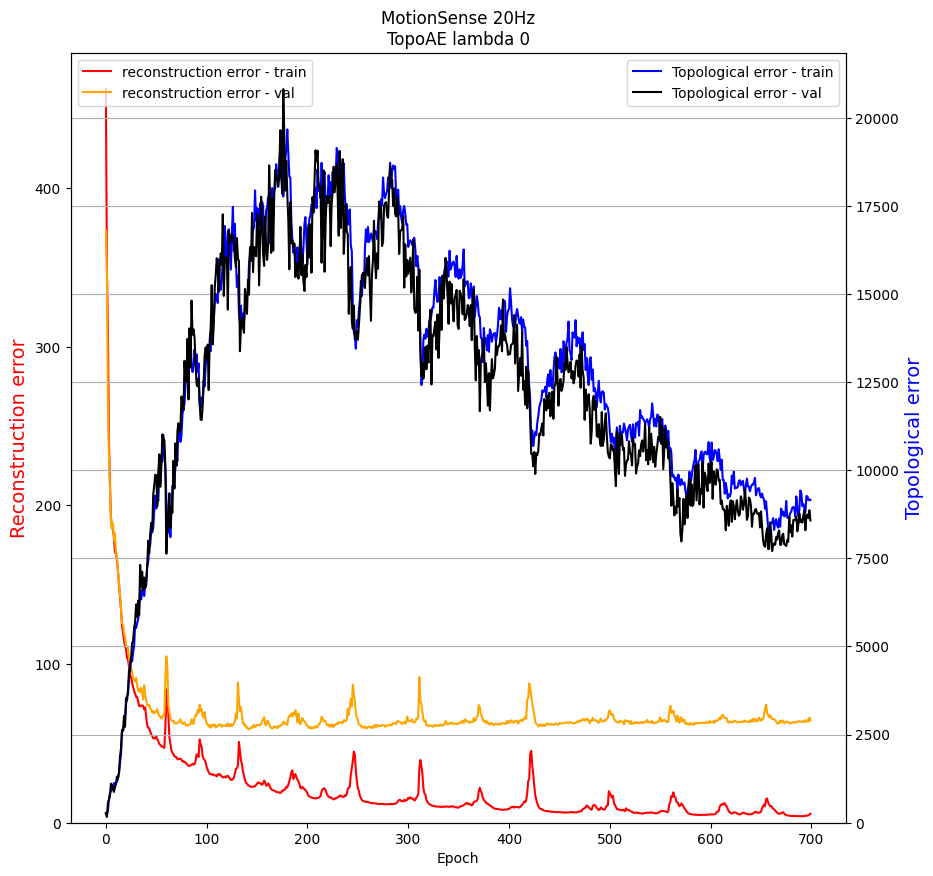

In [20]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [21]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [22]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [23]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7922764227642277,
 'RF-F1': 0.7906032577907947,
 'SVC-ACC': 0.6869918699186992,
 'SVC-F1': 0.7415528699734629,
 'KNN-ACC': 0.8130081300813008,
 'KNN-F1': 0.8107988147727424}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


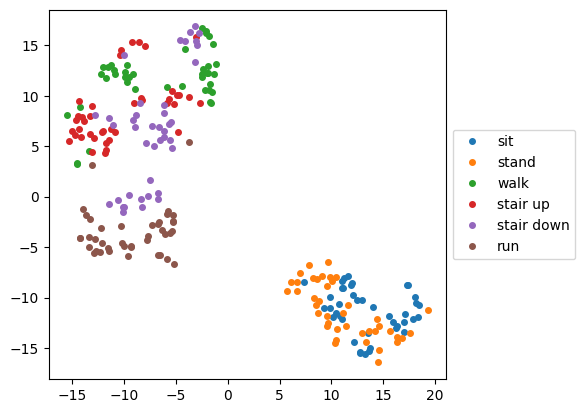

In [24]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=1)

In [25]:
model_lam = 1
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:435.4431, Loss-ae:426.3513, Loss-topo:9.0918
Epoch:2, P:None, Loss:364.6860, Loss-ae:357.7459, Loss-topo:6.9401
Epoch:3, P:None, Loss:333.0893, Loss-ae:331.0409, Loss-topo:2.0484
Epoch:4, P:None, Loss:331.3551, Loss-ae:329.5646, Loss-topo:1.7904
Epoch:5, P:None, Loss:268.5536, Loss-ae:259.8929, Loss-topo:8.6607
Epoch:6, P:None, Loss:249.8124, Loss-ae:245.2481, Loss-topo:4.5643
Epoch:7, P:None, Loss:232.1794, Loss-ae:228.3261, Loss-topo:3.8534
Epoch:8, P:None, Loss:215.9345, Loss-ae:212.2932, Loss-topo:3.6413
Epoch:9, P:None, Loss:208.8681, Loss-ae:206.0863, Loss-topo:2.7818
Epoch:10, P:None, Loss:198.8381, Loss-ae:195.9735, Loss-topo:2.8646
Epoch:11, P:None, Loss:185.5355, Loss-ae:182.8766, Loss-topo:2.6589
Epoch:12, P:None, Loss:179.9219, Loss-ae:177.5987, Loss-topo:2.3232
Epoch:13, P:None, Loss:177.9014, Loss-ae:175.3528, Loss-topo:2.5486
Epoch:14, P:None, Loss:176.2385, Loss-ae:173.8854, Loss-topo:2.3531
Epoch:15, P:None, Loss:176.0468, Loss-ae:173.9214, Loss-t

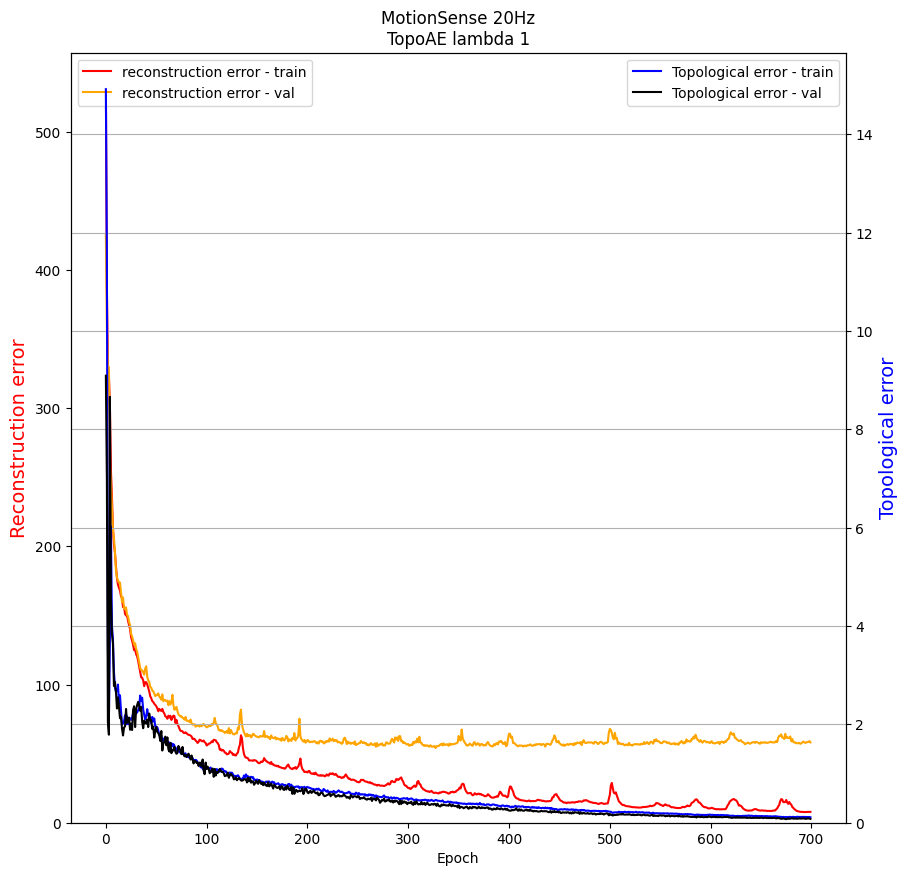

In [26]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [27]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [28]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [29]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8024390243902438,
 'RF-F1': 0.8010715810897574,
 'SVC-ACC': 0.7276422764227642,
 'SVC-F1': 0.7269471654364112,
 'KNN-ACC': 0.7439024390243902,
 'KNN-F1': 0.7422065327507593}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


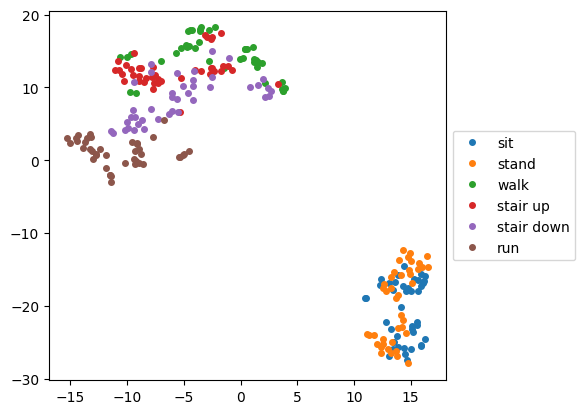

In [30]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=5)

In [31]:
model_lam = 5
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:448.5485, Loss-ae:438.9584, Loss-topo:1.9180
Epoch:2, P:None, Loss:361.7545, Loss-ae:357.8191, Loss-topo:0.7871
Epoch:3, P:None, Loss:334.1349, Loss-ae:332.0344, Loss-topo:0.4201
Epoch:4, P:None, Loss:332.2795, Loss-ae:330.5261, Loss-topo:0.3507
Epoch:5, P:None, Loss:329.4666, Loss-ae:328.4413, Loss-topo:0.2051
Epoch:6, P:None, Loss:317.6616, Loss-ae:315.4538, Loss-topo:0.4416
Epoch:7, P:None, Loss:249.9658, Loss-ae:244.9122, Loss-topo:1.0107
Epoch:8, P:None, Loss:231.7067, Loss-ae:228.3642, Loss-topo:0.6685
Epoch:9, P:None, Loss:222.0311, Loss-ae:218.7738, Loss-topo:0.6515
Epoch:10, P:None, Loss:211.3284, Loss-ae:208.3401, Loss-topo:0.5976
Epoch:11, P:None, Loss:207.5228, Loss-ae:204.6919, Loss-topo:0.5662
Epoch:12, P:None, Loss:204.9339, Loss-ae:202.1675, Loss-topo:0.5533
Epoch:13, P:None, Loss:190.3419, Loss-ae:187.4447, Loss-topo:0.5794
Epoch:14, P:None, Loss:177.1138, Loss-ae:174.3171, Loss-topo:0.5593
Epoch:15, P:None, Loss:172.7162, Loss-ae:170.4057, Loss-t

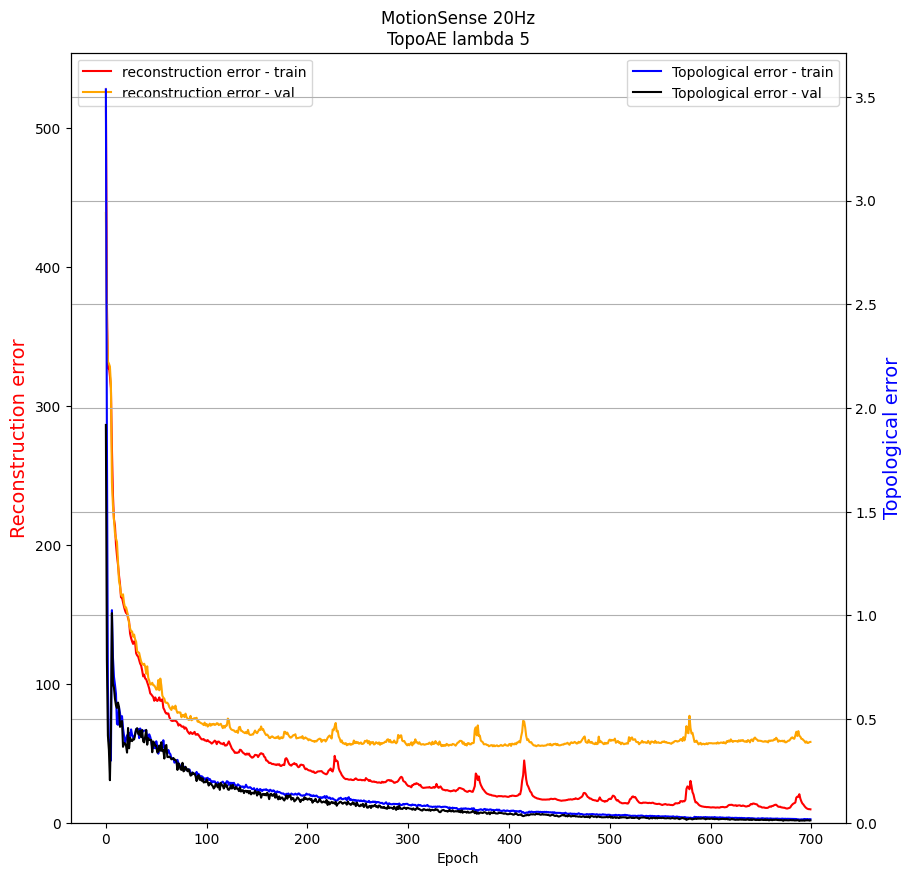

In [32]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [33]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [34]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [35]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7861788617886178,
 'RF-F1': 0.7842982948720503,
 'SVC-ACC': 0.7073170731707317,
 'SVC-F1': 0.7022740658979829,
 'KNN-ACC': 0.7723577235772358,
 'KNN-F1': 0.7705435795111786}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


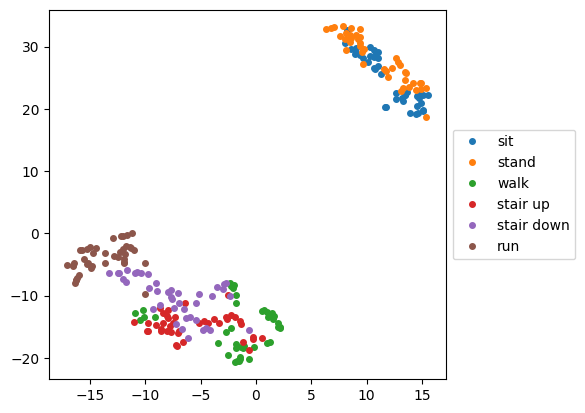

In [36]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=10)

In [37]:
model_lam = 10
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:459.5384, Loss-ae:448.4532, Loss-topo:1.1085
Epoch:2, P:None, Loss:391.4089, Loss-ae:386.7133, Loss-topo:0.4696
Epoch:3, P:None, Loss:336.6926, Loss-ae:333.5444, Loss-topo:0.3148
Epoch:4, P:None, Loss:331.0232, Loss-ae:329.0756, Loss-topo:0.1948
Epoch:5, P:None, Loss:329.0251, Loss-ae:327.6583, Loss-topo:0.1367
Epoch:6, P:None, Loss:320.7099, Loss-ae:319.4977, Loss-topo:0.1212
Epoch:7, P:None, Loss:260.4377, Loss-ae:254.3528, Loss-topo:0.6085
Epoch:8, P:None, Loss:249.3815, Loss-ae:245.4538, Loss-topo:0.3928
Epoch:9, P:None, Loss:225.0887, Loss-ae:220.6218, Loss-topo:0.4467
Epoch:10, P:None, Loss:218.1285, Loss-ae:214.7836, Loss-topo:0.3345
Epoch:11, P:None, Loss:214.1537, Loss-ae:210.8995, Loss-topo:0.3254
Epoch:12, P:None, Loss:211.1012, Loss-ae:208.5742, Loss-topo:0.2527
Epoch:13, P:None, Loss:197.3273, Loss-ae:194.6859, Loss-topo:0.2641
Epoch:14, P:None, Loss:187.2699, Loss-ae:184.5911, Loss-topo:0.2679
Epoch:15, P:None, Loss:174.1739, Loss-ae:171.3365, Loss-t

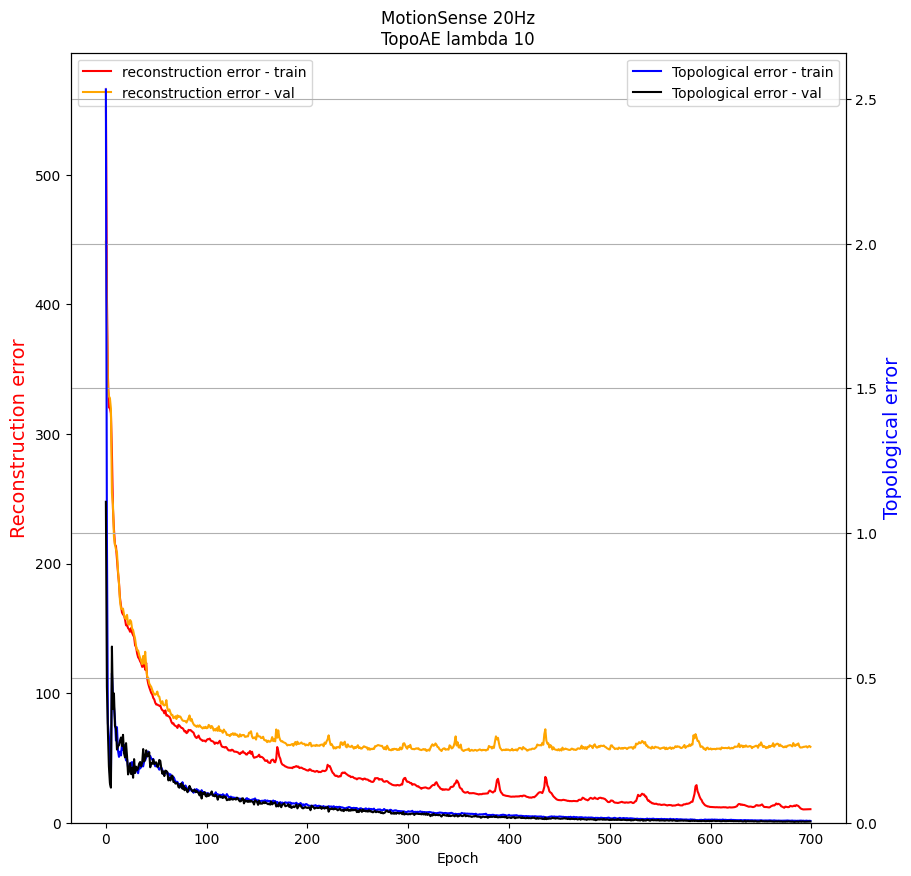

In [38]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [39]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [40]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [41]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7800813008130081,
 'RF-F1': 0.7798948626320727,
 'SVC-ACC': 0.7642276422764228,
 'SVC-F1': 0.7651850139141259,
 'KNN-ACC': 0.7479674796747967,
 'KNN-F1': 0.7460927624316913}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


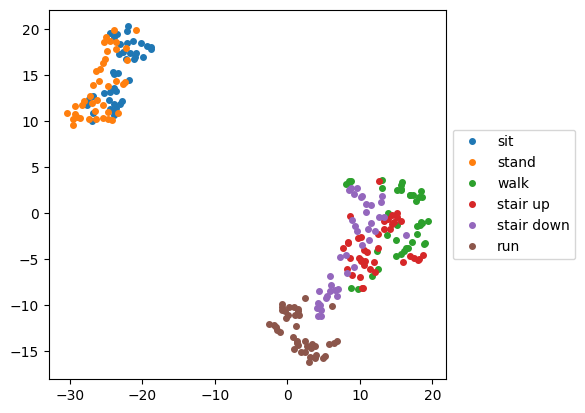

In [42]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=100)

In [43]:
model_lam = 100
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:448.9693, Loss-ae:401.7572, Loss-topo:0.4721
Epoch:2, P:None, Loss:356.6597, Loss-ae:343.9587, Loss-topo:0.1270
Epoch:3, P:None, Loss:339.2723, Loss-ae:336.2632, Loss-topo:0.0301
Epoch:4, P:None, Loss:334.6440, Loss-ae:332.4844, Loss-topo:0.0216
Epoch:5, P:None, Loss:333.0931, Loss-ae:331.7136, Loss-topo:0.0138
Epoch:6, P:None, Loss:324.0033, Loss-ae:322.9452, Loss-topo:0.0106
Epoch:7, P:None, Loss:303.8278, Loss-ae:299.9484, Loss-topo:0.0388
Epoch:8, P:None, Loss:265.2903, Loss-ae:259.2501, Loss-topo:0.0604
Epoch:9, P:None, Loss:255.5340, Loss-ae:250.6035, Loss-topo:0.0493
Epoch:10, P:None, Loss:249.5475, Loss-ae:246.3197, Loss-topo:0.0323
Epoch:11, P:None, Loss:237.7666, Loss-ae:235.0576, Loss-topo:0.0271
Epoch:12, P:None, Loss:237.2423, Loss-ae:235.3485, Loss-topo:0.0189
Epoch:13, P:None, Loss:228.7834, Loss-ae:227.2794, Loss-topo:0.0150
Epoch:14, P:None, Loss:221.5647, Loss-ae:220.1141, Loss-topo:0.0145
Epoch:15, P:None, Loss:210.1519, Loss-ae:207.5508, Loss-t

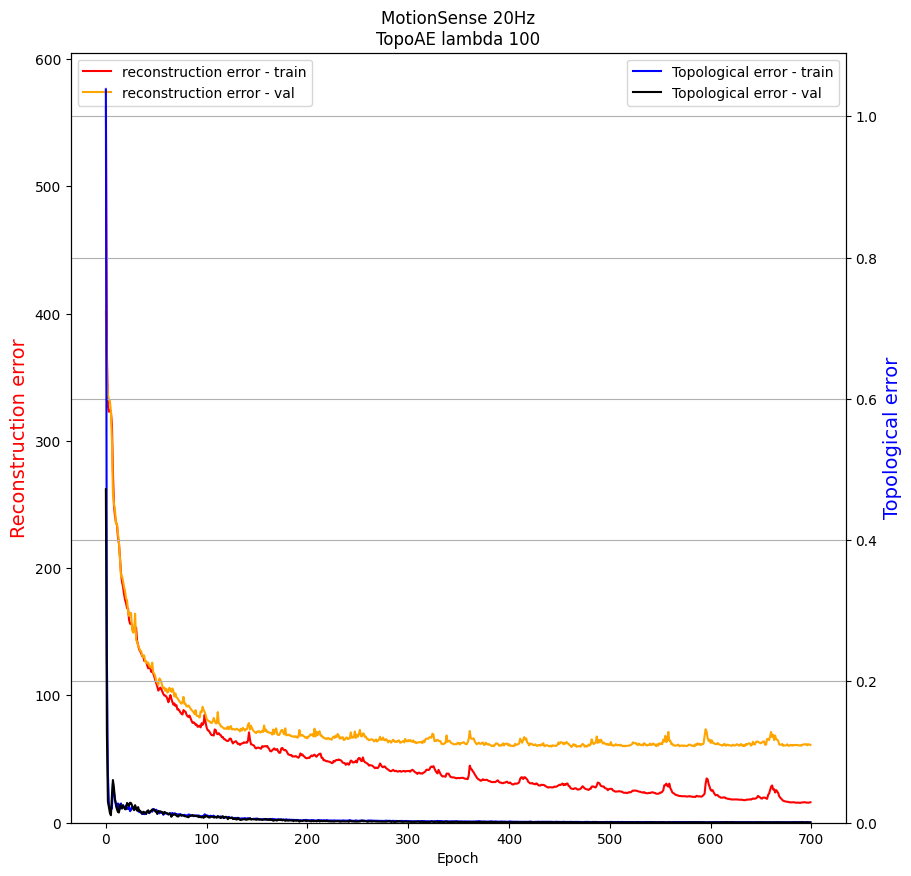

In [44]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [45]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [46]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [47]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8191056910569106,
 'RF-F1': 0.8181572824963477,
 'SVC-ACC': 0.7520325203252033,
 'SVC-F1': 0.7563273037899998,
 'KNN-ACC': 0.7723577235772358,
 'KNN-F1': 0.7702228881739609}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


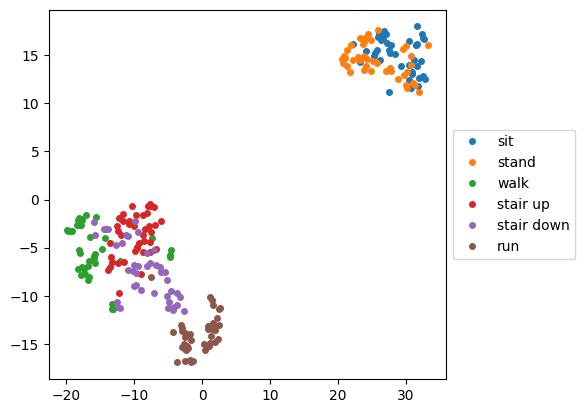

In [48]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

In [49]:
# Reducing with Convolutional Topological Autoencoders

In [50]:
# model_lam = 1
# model_dim = 10
# model_epc = 200
# topo_reducer = TopologicalDimensionalityReduction(
#     ae_model='ConvolutionalAutoencoder_custom_dim',
#     lam = model_lam,
#     ae_kwargs = {'input_dims':(1, 360), 'custom_dim':model_dim},
#     input_shape = (-1, 1, 1, 360),
#     patience = None,
#     num_epochs = model_epc
# )

In [51]:
# title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
# topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [52]:
# train_LD = topo_reducer.transform(train_HD)
# test_LD = topo_reducer.transform(test_HD)

In [53]:
# train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
# print('TRAIN LD RESHAPED', train_LD.shape)
# test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
# print('TEST LD RESHAPED', test_LD.shape)

In [54]:
# experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
# experiments_result